In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
from cvxopt import matrix, solvers

In [49]:
from tqdm import tqdm

In [5]:
w=0.1

In [6]:
P=np.zeros((100,4,100))

In [7]:
def is_valid_state(s):
    return (s>=0) and (s<100)

In [8]:
def is_valid_action(a):
    return (a>=0) and (a<4)

In [9]:
def get_row(s):
    return s%10

In [10]:
def get_column(s):
    return s//10

In [11]:
def is_internal_state(s):
    r=is_valid_state(s-1) and is_valid_state(s+1) and is_valid_state(s-10) and is_valid_state(s+10)
    return r and ((get_row(s-10)==get_row(s)) and (get_row(s+10)==get_row(s)) and (get_column(s-1)==get_column(s)) and (get_column(s+1)==get_column(s)))

In [12]:
#up=0, right=1, down=2, left=3

In [13]:
def state_after_action(s, a):
    if(not(is_valid_state(s))): raise NameError("Invalid state")
    if(not(is_valid_action(a))): raise NameError("Invalid action")
    s1=s
    if(a==0):
        if(is_valid_state(s-1) and (get_column(s-1)==get_column(s))): s1=s-1
    elif(a==1):
        if(is_valid_state(s+10) and (get_row(s+10)==get_row(s))): s1=s+10
    elif(a==2):
        if(is_valid_state(s+1) and (get_column(s+1)==get_column(s))): s1=s+1
    elif(a==3):
        if(is_valid_state(s-10) and (get_row(s-10)==get_row(s))): s1=s-10
    return s1

In [14]:
def evaluate_P(w=0.1):
    P=np.zeros((100,4,100))
    for s in range(100):
        for a in range(4):
            P[s][a][state_after_action(s,a)]+=1-w
            for a1 in range(4):
                P[s][a][state_after_action(s,a1)]+=w/4
    return P

In [15]:
P1=evaluate_P(0.1)

In [16]:
R1=np.zeros((100,))

In [17]:
for i in [14,24,15,25,52,62,53,63,28,38,29,39]:
    R1[i]=-10
R1[99]=1

In [18]:
R2=np.zeros((100,))

In [19]:
for i in [41,42,43,44,45,46,51,61,62,63,73,83,84,85,86,87,77,67,68]:
    R2[i]=-100
R2[99]=10

In [20]:
print(pd.DataFrame(R1.reshape(10,10).transpose()))

     0     1     2     3    4     5     6    7    8    9
0  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
1  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
2  0.0   0.0   0.0   0.0  0.0 -10.0 -10.0  0.0  0.0  0.0
3  0.0   0.0   0.0   0.0  0.0 -10.0 -10.0  0.0  0.0  0.0
4  0.0 -10.0 -10.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
5  0.0 -10.0 -10.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
6  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
7  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
8  0.0   0.0 -10.0 -10.0  0.0   0.0   0.0  0.0  0.0  0.0
9  0.0   0.0 -10.0 -10.0  0.0   0.0   0.0  0.0  0.0  1.0


In [21]:
print(pd.DataFrame(R2.reshape(10,10).transpose()))

     0    1    2    3      4      5      6      7      8     9
0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0   0.0
1  0.0  0.0  0.0  0.0 -100.0 -100.0 -100.0    0.0    0.0   0.0
2  0.0  0.0  0.0  0.0 -100.0    0.0 -100.0    0.0    0.0   0.0
3  0.0  0.0  0.0  0.0 -100.0    0.0 -100.0 -100.0 -100.0   0.0
4  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
5  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
6  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
7  0.0  0.0  0.0  0.0    0.0    0.0 -100.0 -100.0 -100.0   0.0
8  0.0  0.0  0.0  0.0    0.0    0.0 -100.0    0.0    0.0   0.0
9  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0  10.0


In [22]:
V1=np.zeros((100,1))

In [23]:
gamma=0.8
epsilon=0.01

In [68]:
def fast_value_iteration(P,R,epsilon=0.01,gamma=0.8):
    V=np.zeros((100,))
    delta=np.inf
    while delta>epsilon:
        v_next=np.amax(np.matmul(P,R+gamma*V), axis=1)
        delta=np.amax(np.abs(v_next-V))
        V=v_next
    policy=np.argmax(np.matmul(P,R+gamma*V), axis=1)
    return [V, policy]

In [27]:
def value_iteration(P,R,epsilon=0.01,gamma=0.8):
    V=np.zeros((100,1))
    policy=np.zeros((100,), dtype=int)
    delta=np.inf
    iter=0
    while delta>epsilon:
        delta=0
        for s in range(100):
            v_next=-np.inf
            for a in range(4):
                v_temp=0
                for s1 in range(100):
                    v_temp+=P[s][a][s1]*(R[s1]+gamma*V[s1])
                v_next = max(v_next, v_temp)
            delta=max(delta,np.abs(v_next-V[s]))
            V[s]=v_next
    for s in range(100):
        v_next=-np.inf
        opt_a=-1
        for a in range(4):
            v_temp=0
            for s1 in range(100):
                v_temp+=P[s][a][s1]*(R[s1]+gamma*V[s1])
            if(v_temp>v_next):
                opt_a=a
                v_next = v_temp
        policy[s]=opt_a
    return [V, policy]

In [247]:
def draw_heatmap(A):
    fig, ax = plt.subplots()
    im=ax.imshow(A.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
    ax.grid(color='k', linewidth=0.1)
    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    fig.colorbar(im)
    plt.show()

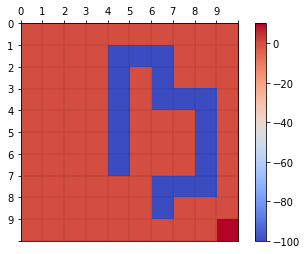

In [248]:
draw_heatmap(R2)

In [207]:
def draw_policy_grid(policy):
    policy_arrows=np.chararray((100,), unicode=True)
    for s in range(100):
        a=policy[s]
        if(a==0):
            policy_arrows[s]='↑'
        elif(a==1):
            policy_arrows[s]='→'
        elif(a==2):
            policy_arrows[s]='↓'
        elif(a==3):
            policy_arrows[s]='←'
    pa=policy_arrows.reshape(10,10)
    board = np.ones((10,10,3))
    fig, ax = plt.subplots()
    ax.imshow(board, interpolation='nearest', aspect='auto')
    ax.grid(color='k', linewidth=1)

    for i in range(10):
        for j in range(10):
            ax.text(i, j, pa[i][j], size=19, ha='center', va='center')

    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    ax.axis('image')

    plt.show()

In [79]:
def draw_policy(policy):
    policy_arrows=np.chararray((100,), unicode=True)
    for s in range(100):
        a=policy[s]
        if(a==0):
            policy_arrows[s]='↑'
        elif(a==1):
            policy_arrows[s]='→'
        elif(a==2):
            policy_arrows[s]='↓'
        elif(a==3):
            policy_arrows[s]='←'
    print(pd.DataFrame(policy_arrows.reshape(10,10).transpose()))

In [35]:
V1, policy1=value_iteration(P1,R1)

In [36]:
print(pd.DataFrame(V1.reshape(10,10).transpose()))

          0         1         2         3         4         5         6  \
0  0.034184  0.053623  0.078772  0.111036  0.152416  0.205748  0.281056   
1  0.027161  0.042216  0.061703  0.086546  0.108552 -0.105918  0.090649   
2  0.020837  0.027323  0.042589  0.062113 -0.178936 -0.592498 -0.256072   
3  0.004851 -0.248738 -0.229786  0.054929  0.082457 -0.252576 -0.103050   
4 -0.271550 -0.711764 -0.469517  0.085998  0.468917  0.360402  0.544964   
5 -0.256961 -0.625632 -0.365881  0.215098  0.628854  0.813767  1.048608   
6  0.031436 -0.124235  0.193076  0.617776  0.818799  1.054084  1.353224   
7  0.061552  0.089079  0.136762  0.535698  1.042798  1.352966  1.734448   
8  0.042599 -0.196964 -0.416322  0.297379  1.076282  1.727458  2.219408   
9  0.027114 -0.258487 -0.963587  0.277586  1.408604  2.176171  2.806674   

          7         8         9  
0  0.374033  0.484771  0.609198  
1  0.472000  0.625150  0.786938  
2  0.355456  0.807146  1.018277  
3  0.543076  1.046190  1.314922  
4  1

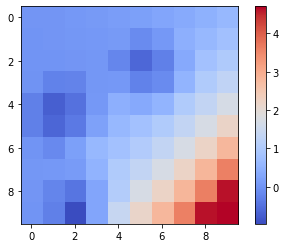

In [213]:
plt.imshow(V1.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

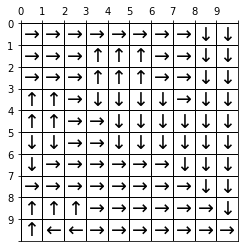

In [231]:
draw_policy_grid(policy1)

In [52]:
V2, policy2=fast_value_iteration(P1,R2)

In [53]:
print(pd.DataFrame(V2.reshape(10,10).transpose()))

          0         1         2          3          4          5          6  \
0  0.646710  0.790798  0.820813   0.525100  -2.386476  -4.236930  -1.923374   
1  0.827724  1.017733  1.061580  -1.879217  -6.754669  -8.683714  -6.373483   
2  1.061312  1.313001  1.445788  -1.635211  -6.757757 -13.916635  -9.653202   
3  1.357786  1.689182  1.943907  -1.243217  -6.339216  -7.982771  -7.947292   
4  1.733934  2.168079  2.585895  -0.736490  -5.846727  -3.258403  -3.241071   
5  2.211119  2.777553  3.413345  -0.038140  -5.114112  -0.553380  -0.487536   
6  2.816429  3.552963  4.478824   3.024358   2.480209   2.880151  -0.465523   
7  3.584202  4.539186  5.792569   7.288420   6.718773   7.241102   0.930890   
8  4.557967  5.794705  7.397203   9.439455  12.008201  12.889183  17.097345   
9  5.726633  7.316079  9.387596  12.044687  15.452355  19.823974  25.497506   

           7          8          9  
0   1.128097   1.591162   2.034827  
1  -1.298361   1.924775   2.606893  
2  -5.514815  -0.13

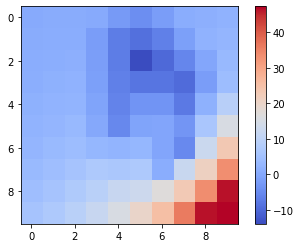

In [212]:
plt.imshow(V2.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

In [55]:
print(pd.DataFrame(policy2.reshape(10,10).transpose()))

   0  1  2  3  4  5  6  7  8  9
0  2  2  2  3  3  1  1  1  1  2
1  2  2  2  3  3  0  1  1  1  2
2  2  2  2  3  3  2  1  1  1  2
3  2  2  2  3  3  2  2  0  1  2
4  2  2  2  3  3  2  2  2  1  2
5  2  2  2  3  3  2  2  3  1  2
6  2  2  2  2  2  2  3  3  1  2
7  2  2  2  2  2  2  3  2  2  2
8  1  1  1  2  2  2  2  2  2  2
9  1  1  1  1  1  1  1  1  1  1


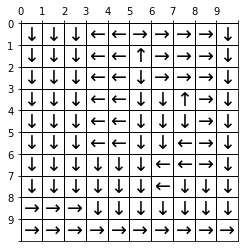

In [232]:
draw_policy_grid(policy2)

In [44]:
R2max=np.amax(np.abs(R2))

In [45]:
def construct_lp_matrices(P,policy,lmda,Rmax):
    S=np.shape(P)[0]
    c=np.concatenate([np.ones((S,)), -lmda*np.ones((S,)), np.zeros((S,))])
    A=np.array([])
    nA=4
    
    Pa1=np.zeros((S,S))
    Pas=np.zeros((3,S,S))
    
    for s in range(S):
        opt_a=policy[s]
        Pa1[s,:]=P[s][opt_a]
        other_actions=np.setdiff1d(range(nA), opt_a)
        for i,a in enumerate(other_actions):
            Pas[i,s,:]=P[s][a]
            
    I, Z=np.eye(S), np.zeros((S,S))
    for i in range(nA-1):
        Pa=Pas[i]
        temp=np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))
        temp=np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))))
        if (A.shape[0]==0): A=temp
        else: A=np.vstack((temp, A))
            
    A=np.vstack((A, np.hstack((Z, -I, I))))
    A=np.vstack((A, np.hstack((Z, -I, -I))))
    A=np.vstack((A, np.hstack((Z, Z, I))))
    A=np.vstack((A, np.hstack((Z, Z, -I))))
    b=np.concatenate([np.zeros((2*(nA-1)*S+2*S,)), Rmax*np.ones((2*S,))])
    return [c,A,b]

In [149]:
def construct_lp_matrices_modified(P,policy,lmda,Rmax,Rmin):
    S=np.shape(P)[0]
    c=np.concatenate([np.ones((S,)), -lmda*np.ones((S,)), np.zeros((S,))])
    A=np.array([])
    nA=4
    
    Pa1=np.zeros((S,S))
    Pas=np.zeros((3,S,S))
    
    for s in range(S):
        opt_a=policy[s]
        Pa1[s,:]=P[s][opt_a]
        other_actions=np.setdiff1d(range(nA), opt_a)
        for i,a in enumerate(other_actions):
            Pas[i,s,:]=P[s][a]
            
    I, Z=np.eye(S), np.zeros((S,S))
    for i in range(nA-1):
        Pa=Pas[i]
        temp=np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))
        if (A.shape[0]==0): A=temp
        else: A=np.vstack((temp, A))
            
    A=np.vstack((A, np.hstack((-I, Z, Z))))
    A=np.vstack((A, np.hstack((Z, -I, I))))
    A=np.vstack((A, np.hstack((Z, -I, -I))))
    A=np.vstack((A, np.hstack((Z, Z, I))))
    A=np.vstack((A, np.hstack((Z, Z, -I))))
    b=np.concatenate([np.zeros(((nA-1)*S+3*S,)), Rmax*np.ones((S,)), -Rmin*np.ones((S,))])
    return [c,A,b]

In [120]:
def solve_irl_modified(P,policy,Rmax,Rmin,lmda=None):
    if lmda is None: raise NameError("Please specify lambda")
    solvers.options['show_progress']=False
    c,A,b=construct_lp_matrices_modified(P,policy,lmda,Rmax,Rmin)
    solution=solvers.lp(-matrix(c.transpose()),matrix(A),matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [119]:
def solve_irl(P,policy,Rmax,lmda=None):
    if lmda is None: raise NameError("Please specify lambda")
    solvers.options['show_progress']=False
    c,A,b=construct_lp_matrices(P,policy,lmda,Rmax)
    solution=solvers.lp(-matrix(c.transpose()),matrix(A),matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [47]:
def calc_accuracy_over_lmdas(P,target_policy,Rmax,lmdas):
    accuracy=np.zeros_like(lmdas)
    for i,lmda in enumerate(tqdm(lmdas)):
        R_predicted=solve_irl(P,target_policy,Rmax,lmda)
        V,predicted_policy=fast_value_iteration(P,R_predicted)
        accuracy[i]=(predicted_policy==target_policy).sum()/100
    return accuracy

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.84it/s]


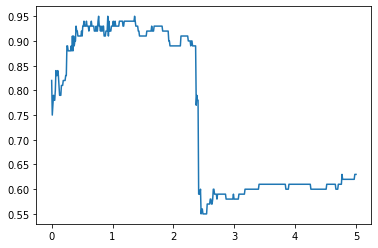

In [57]:
lmdas=np.linspace(0,5,500)
accuracy=calc_accuracy_over_lmdas(P1,policy2,R2max,lmdas)
plt.plot(lmdas,accuracy)

In [61]:
lmda_max_2=lmdas[np.argmax(accuracy)]

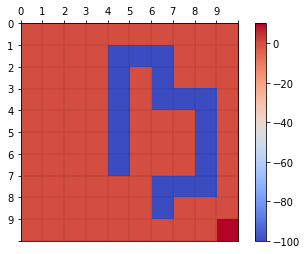

In [249]:
draw_heatmap(R2)

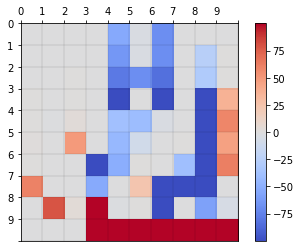

In [250]:
R_predicted=solve_irl(P1,policy2,R2max,lmda_max_2)
draw_heatmap(R_predicted)

In [251]:
V_predicted,predicted_policy=fast_value_iteration(P1,R_predicted)

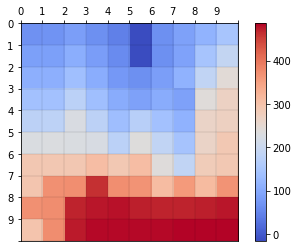

In [252]:
draw_heatmap(V_predicted)

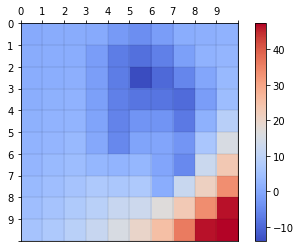

In [253]:
draw_heatmap(V2)

In [254]:
(policy2==predicted_policy).sum()

95

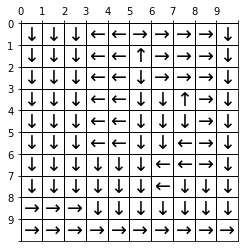

In [255]:
draw_policy_grid(policy2)

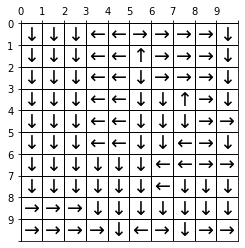

In [256]:
draw_policy_grid(predicted_policy)

In [257]:
V_predicted_modified,predicted_policy_modified=fast_value_iteration(P1,R_predicted,epsilon=0.00001)

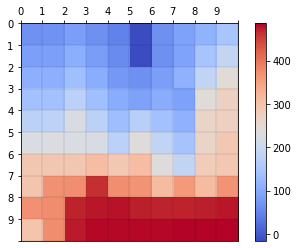

In [258]:
draw_heatmap(V_predicted_modified)

In [259]:
(policy2==predicted_policy_modified).sum()

100

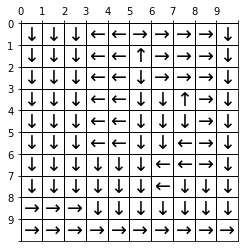

In [260]:
draw_policy_grid(policy2)

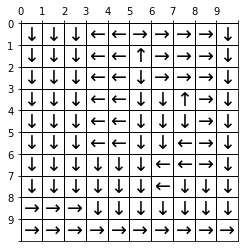

In [261]:
draw_policy_grid(predicted_policy_modified)

In [262]:
R2mx, R2mn=np.amax(R2), np.amin(R2)

In [263]:
R_predicted_mod=solve_irl_modified(P1,policy2,R2mx,R2mn,lmda_max_2)

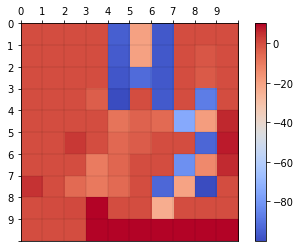

In [264]:
draw_heatmap(R_predicted_mod)

In [221]:
V_predicted_mod,predicted_policy_mod=fast_value_iteration(P1,R_predicted_mod,epsilon=0.0001)

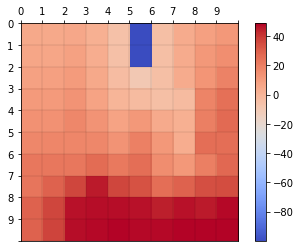

In [266]:
draw_heatmap(V_predicted_mod)

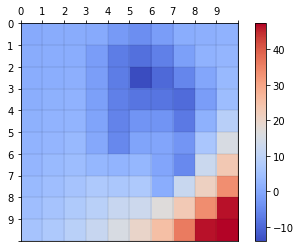

In [265]:
draw_heatmap(V2)

In [224]:
(policy2==predicted_policy_mod).sum()

96

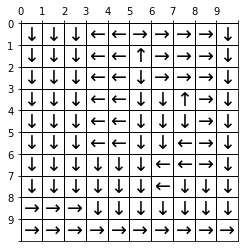

In [225]:
draw_policy_grid(policy2)

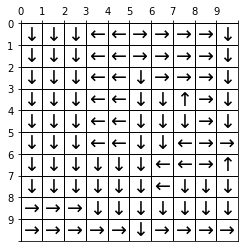

In [226]:
draw_policy_grid(predicted_policy_mod)